# Download Uppsala Collection & Semantic Image Search with CLIP

In this notebook, you will:

1. **Download** the Uppsala University collection from Europeana (thumbnail resolution)
2. **Learn** how CLIP connects images and text
3. **Search** the collection using natural language (e.g., "waterbody", "portrait")
4. **Explore** how different queries find different images

---

## What is CLIP?

**CLIP** (Contrastive Language-Image Pre-training) is a neural network trained by OpenAI that learns to connect images and text. It can:

- **Understand images** by converting them into numerical representations (embeddings)
- **Understand text** by converting descriptions into the same embedding space
- **Match** images and text by measuring how similar their embeddings are

This allows us to search for images using natural language descriptions like:
- "a painting of a stormy sea"
- "winter landscape with snow"
- "flowers in a vase"

### How CLIP Works

```mermaid
flowchart LR
    subgraph Input
        IMG["🖼️ Image"]
        TXT["📝 Text\n'a river landscape'"]
    end
    
    subgraph CLIP["CLIP Model"]
        IE["Image\nEncoder"]
        TE["Text\nEncoder"]
    end
    
    subgraph Embeddings["Embedding Space"]
        IV["[0.12, -0.45, 0.78, ...]"]
        TV["[0.11, -0.42, 0.81, ...]"]
    end
    
    SIM["📊 Cosine\nSimilarity\n= 0.94"]
    
    IMG --> IE --> IV
    TXT --> TE --> TV
    IV --> SIM
    TV --> SIM
```

The key insight: **similar concepts end up close together** in embedding space, whether they come from images or text!

---

## Pre-calculated Embeddings

Computing image embeddings requires significant computational resources (ideally a GPU). For this workshop, we use **pre-calculated embeddings**:

- Image embeddings were computed beforehand by the instructor
- You only need to compute **text embeddings** (fast on any laptop)
- This makes the workshop accessible on any hardware!

If you want to compute your own embeddings, see **Notebook 04 (Advanced)**.

---

## Part 1: Setup and Imports

In [1]:
# Standard library imports
import os
import json
import time
from pathlib import Path

# External libraries
import numpy as np
import requests
from PIL import Image as PILImage
from IPython.display import display, Image, HTML

# Import CLIP
try:
    import torch
    import clip
    CLIP_AVAILABLE = True
    print(f"✓ CLIP loaded successfully!")
except ImportError:
    CLIP_AVAILABLE = False
    print("⚠️ CLIP not installed.")
    print("  Install with: pip install git+https://github.com/openai/CLIP.git torch torchvision")

# Check for GPU
if CLIP_AVAILABLE:
    if torch.cuda.is_available():
        print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
        DEVICE = 'cuda'
    else:
        print("ℹ️ No GPU detected. Using CPU (fine for text encoding).")
        DEVICE = 'cpu'

✓ CLIP loaded successfully!
✓ GPU available: NVIDIA RTX A1000 6GB Laptop GPU


In [2]:
# Set up paths
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR.parent

# ============================================================
# Collection to work with — change this to switch collections!
# ============================================================
COLLECTION_NAME = "Museum of Gothenburg"  # <-- Change this!
# ============================================================

safe_name = COLLECTION_NAME.lower().replace(' ', '_')
COLLECTION_IMAGES_DIR      = PROJECT_ROOT / "data" / "images"     / COLLECTION_NAME
COLLECTION_EMBEDDINGS_FILE = PROJECT_ROOT / "data" / "embeddings" / COLLECTION_NAME / f"{safe_name}_clip_embeddings.npz"
DATA_DIR = PROJECT_ROOT / "data"

# Create base directories
(PROJECT_ROOT / "data" / "images").mkdir(parents=True, exist_ok=True)
(PROJECT_ROOT / "data" / "embeddings" / COLLECTION_NAME).mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Collection:   {COLLECTION_NAME}")
print(f"Images:       {COLLECTION_IMAGES_DIR}")
print(f"Embeddings:   {COLLECTION_EMBEDDINGS_FILE}")
print(f"Embeddings exist: {COLLECTION_EMBEDDINGS_FILE.exists()}")

Project root: /home/lauhp/000_PHD/000_003_Code/DH-Workshop
Collection:   Museum of Gothenburg
Images:       /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum of Gothenburg
Embeddings:   /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum of Gothenburg/museum_of_gothenburg_clip_embeddings.npz
Embeddings exist: False


---

## Part 2: Download from a Swedish collection


  1. Swedish National Heritage Board                            (1,414,618 items)
  2. Nordic Museum Foundation                                   (351,553 items)
  3. Malmö Museum                                               (288,308 items)
  4. Museum of Ethnography                                      (271,525 items)
  5. Museum of World Culture                                    (230,176 items)
  6. Upplands Museum                                            (218,928 items)
  7. Jamtli                                                     (173,095 items)
  8. Museum of Gothenburg                                       (171,960 items)
  9. Swedish National Museum of Science and Technology          (150,809 items)
 10. Swedish Railway Museum                                     (145,093 items)
 11. Naval Museum                                               (143,623 items)
 12. Bohuslän Museum                                            (140,521 items)
 13. Gävleborg County Museum                                    (133,207 items)
 14. Kulturen                                                   (130,732 items)
 15. Örebro County Museum                                       (125,272 items)
 16. Västergötlands Museum                                      (117,479 items)
 17. Army Museum                                                (114,513 items)
 18. Sörmland Museum                                            (107,177 items)
 19. National Maritime Museum                                   (103,829 items)
 20. Vänersborgs museum                                         (103,249 items)
 21. The Museum of Mediterranean and Near Eastern Antiquities... (74,761 items)
 22. Museum of Far Eastern Antiquities                          (74,426 items)
 23. Uppsala University                                         (74,233 items)
 24. Hälsinglands Museum                                        (73,678 items)
 25. Swedish Centre for Architecture and Design                 (67,581 items)

In [3]:
# API Setup (same as Notebook 01)
BASE_URL = "https://api.europeana.eu/record/v2"

# Load API key
NOTEBOOK_DIR = Path(".").resolve()
API_KEY_LOCATIONS = [
    NOTEBOOK_DIR / "api-key-europeana.txt",
    PROJECT_ROOT / "misc" / "api-key-europeana.txt",
]

API_KEY = "api2demo"
for key_file in API_KEY_LOCATIONS:
    if key_file.exists():
        with open(key_file, 'r') as f:
            custom_key = f.read().strip()
            if custom_key and custom_key != "api2demo":
                API_KEY = custom_key
                print(f"✓ API key loaded from {key_file}")
                break
else:
    print("ℹ️ Using demo API key")

✓ API key loaded from /home/lauhp/000_PHD/000_003_Code/DH-Workshop/notebooks/api-key-europeana.txt


In [4]:
# Helper functions (from Notebook 01)

def search_europeana(query="*", rows=12, reusability="open", qf=None, profile="rich", cursor=None):
    """Search the Europeana collection."""
    url = f"{BASE_URL}/search.json"
    params = {
        "wskey": API_KEY,
        "query": query,
        "rows": min(rows, 100),
        "profile": profile
    }
    if reusability:
        params["reusability"] = reusability
    if qf:
        params["qf"] = qf
    if cursor:
        params["cursor"] = cursor
    
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"❌ Error: {e}")
        return None


def get_item_title(item):
    if 'title' in item and item['title']:
        return item['title'][0] if isinstance(item['title'], list) else item['title']
    return "Untitled"


def get_item_preview(item):
    if 'edmPreview' in item and item['edmPreview']:
        return item['edmPreview'][0] if isinstance(item['edmPreview'], list) else item['edmPreview']
    return None


def sanitize_filename(name):
    if not name:
        return "unknown"
    safe = "".join(c for c in name if c.isalnum() or c in ' ._-')
    return safe.strip()[:80]

In [5]:
# Check what the selected collection has in Europeana
print(f"Checking {COLLECTION_NAME} collection...")
print("=" * 60)

result = search_europeana(
    query="*",
    rows=5,
    qf=[f'DATA_PROVIDER:"{COLLECTION_NAME}"', "TYPE:IMAGE"],
    reusability="open"
)

if result and result.get('success'):
    print(f"✓ {COLLECTION_NAME} has {result['totalResults']:,} open images")
    print("\nSample items:")
    for item in result['items'][:20]:
        print(f"  - {get_item_title(item)[:60]}")

Checking Museum of Gothenburg collection...
✓ Museum of Gothenburg has 132,080 open images

Sample items:
  - pistol, skjutvapen
  - serveringskärl, tallrik
  - tallrik
  - serveringskärl, tallrik
  - serveringskärl, tallrik


In [6]:
# ============================================================
# EXERCISE: Download images from the selected collection
# ============================================================

# How many images to download?
MAX_DOWNLOAD = 100000  # <-- Start small, increase if needed

# Actually download? (Set to True when ready)
DO_DOWNLOAD = True  # <-- Change to True to download

# Only download paintings? (Filters out photographs etc.)
FILTER_PAINTINGS = True  # <-- Set to True to filter for paintings only

# ============================================================

if DO_DOWNLOAD:
    print(f"📥 Downloading up to {MAX_DOWNLOAD} images from {COLLECTION_NAME}...")
    print(f"   Saving to: {COLLECTION_IMAGES_DIR}")
    print("=" * 60)

    COLLECTION_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

    # Build filters
    qf = [f'DATA_PROVIDER:"{COLLECTION_NAME}"', "TYPE:IMAGE"]
    if FILTER_PAINTINGS:
        qf.append("what:målning")
        print("   Filter: paintings only")

    # Search for images
    results = search_europeana(
        query="*",
        rows=MAX_DOWNLOAD,
        qf=qf,
        reusability="open"
    )

    if results and results.get('items'):
        downloaded = 0

        for i, item in enumerate(results['items'], 1):
            title = get_item_title(item)
            preview_url = get_item_preview(item)
            item_id = item.get('id', 'unknown').replace('/', '_')

            if not preview_url:
                continue

            # Create filename
            safe_title = sanitize_filename(title)[:40]
            filename = f"{item_id}_{safe_title}.jpg"
            filepath = COLLECTION_IMAGES_DIR / filename

            # Skip if exists
            if filepath.exists():
                downloaded += 1
                continue

            # Download
            try:
                response = requests.get(preview_url, timeout=20)
                response.raise_for_status()

                with open(filepath, 'wb') as f:
                    f.write(response.content)

                downloaded += 1
                if downloaded % 20 == 0:
                    print(f"  Downloaded {downloaded}/{len(results['items'])} images...")

                time.sleep(0.3)  # Be nice to the server
            except Exception as e:
                pass

        print(f"\n✓ Downloaded {downloaded} images to {COLLECTION_IMAGES_DIR}")
else:
    print(f"ℹ️ Download skipped. Set DO_DOWNLOAD = True to download images.")

    # Check if we already have images
    if COLLECTION_IMAGES_DIR.exists():
        existing = list(COLLECTION_IMAGES_DIR.glob('*.jpg'))
        print(f"   Found {len(existing)} existing images in {COLLECTION_IMAGES_DIR}")

📥 Downloading up to 100000 images from Museum of Gothenburg...
   Saving to: /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum of Gothenburg
   Filter: paintings only

✓ Downloaded 100 images to /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum of Gothenburg


---

## Part 3: Load CLIP Model and Compute Embeddings

Now let's load CLIP, compute embeddings for the images you downloaded, and load them for search.

- If embeddings **already exist** (e.g. pre-calculated by the instructor), the compute step is skipped automatically.
- If they **don't exist yet**, they are computed from the images in `COLLECTION_IMAGES_DIR` and saved for reuse.

In [7]:
# CLIP model configuration
MODEL_NAME = 'ViT-B/32'  # Good balance of speed and quality

if CLIP_AVAILABLE:
    print(f"Loading CLIP model '{MODEL_NAME}'...")
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
    model.eval()
    print(f"✓ Model loaded on {DEVICE}")
else:
    print("❌ CLIP not available")

Loading CLIP model 'ViT-B/32'...
✓ Model loaded on cuda


In [8]:
# Compute CLIP embeddings for downloaded images
# Skipped automatically if the embeddings file already exists.

BATCH_SIZE = 32  # Reduce if you run out of memory

if not CLIP_AVAILABLE:
    print("❌ CLIP not available — cannot compute embeddings")
elif COLLECTION_EMBEDDINGS_FILE.exists():
    print(f"✓ Embeddings already exist: {COLLECTION_EMBEDDINGS_FILE}")
    print("  Delete the file and re-run this cell to recompute.")
else:
    image_files = sorted(
        f for f in COLLECTION_IMAGES_DIR.glob('*')
        if f.suffix.lower() in ('.jpg', '.jpeg', '.png', '.webp')
    )

    if not image_files:
        print(f"⚠️ No images found in {COLLECTION_IMAGES_DIR}")
        print("   Run Part 2 first to download images.")
    else:
        print(f"Computing embeddings for {len(image_files)} images...")
        print(f"  Model: {MODEL_NAME}  |  Device: {DEVICE}  |  Batch size: {BATCH_SIZE}")

        all_embeddings = []
        all_filenames  = []
        failed         = []

        for i in range(0, len(image_files), BATCH_SIZE):
            batch_files   = image_files[i:i + BATCH_SIZE]
            batch_tensors = []
            batch_names   = []

            for img_path in batch_files:
                try:
                    img = PILImage.open(img_path).convert('RGB')
                    batch_tensors.append(preprocess(img))
                    batch_names.append(img_path.name)
                except Exception as e:
                    failed.append((img_path.name, str(e)))

            if batch_tensors:
                with torch.no_grad():
                    batch = torch.stack(batch_tensors).to(DEVICE)
                    emb   = model.encode_image(batch).float()
                    emb   = emb / emb.norm(dim=-1, keepdim=True)
                all_embeddings.append(emb.cpu().numpy())
                all_filenames.extend(batch_names)

            done = min(i + BATCH_SIZE, len(image_files))
            if done % (BATCH_SIZE * 10) == 0 or done == len(image_files):
                print(f"  Processed {done}/{len(image_files)} images...")

        embeddings_array = np.vstack(all_embeddings)

        np.savez_compressed(
            COLLECTION_EMBEDDINGS_FILE,
            embeddings=embeddings_array,
            filenames=np.array(all_filenames, dtype=object),
            model_name=MODEL_NAME,
            embedding_dim=embeddings_array.shape[1],
        )

        if failed:
            print(f"  ⚠️ Failed to process {len(failed)} images")

        print(f"\n✓ Saved {len(all_filenames)} embeddings → {COLLECTION_EMBEDDINGS_FILE}")
        print(f"  Embeddings shape: {embeddings_array.shape}")

Computing embeddings for 100 images...
  Model: ViT-B/32  |  Device: cuda  |  Batch size: 32
  Processed 100/100 images...

✓ Saved 100 embeddings → /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum of Gothenburg/museum_of_gothenburg_clip_embeddings.npz
  Embeddings shape: (100, 512)


In [9]:
# Load pre-calculated embeddings
# To override the path, uncomment and edit:
# COLLECTION_EMBEDDINGS_FILE = PROJECT_ROOT / "data" / "embeddings" / "my_embeddings.npz"

if COLLECTION_EMBEDDINGS_FILE.exists():
    print(f"Loading pre-calculated embeddings from {COLLECTION_EMBEDDINGS_FILE}...")

    data = np.load(COLLECTION_EMBEDDINGS_FILE, allow_pickle=True)
    image_embeddings = data['embeddings']
    image_filenames = data['filenames']
    saved_model = str(data.get('model_name', 'unknown'))

    print(f"✓ Loaded {len(image_filenames)} image embeddings")
    print(f"  Embeddings shape: {image_embeddings.shape}")
    print(f"  Model used: {saved_model}")

    # Convert to torch tensor
    if CLIP_AVAILABLE:
        image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32).to(DEVICE)
else:
    image_embeddings = None
    image_filenames = None
    print(f"⚠️ Pre-calculated embeddings not found at {COLLECTION_EMBEDDINGS_FILE}")
    print("   Ask your instructor for the embeddings file, or")
    print("   see Notebook 04 to compute your own (requires GPU).")

Loading pre-calculated embeddings from /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum of Gothenburg/museum_of_gothenburg_clip_embeddings.npz...
✓ Loaded 100 image embeddings
  Embeddings shape: (100, 512)
  Model used: ViT-B/32


---

## Part 4: Semantic Search with CLIP

Now the fun part! Let's search for images using natural language.

### Understanding Cosine Similarity

Cosine similarity measures how similar two vectors are:

- **1.0** = Identical direction (very similar)
- **0.0** = Perpendicular (unrelated)
- **-1.0** = Opposite direction (very different)

CLIP embeddings are normalized, so cosine similarity = simple dot product.

In [10]:
def encode_text(text_query):
    """
    Convert a text query into a CLIP embedding.
    """
    with torch.no_grad():
        text_tokens = clip.tokenize([text_query]).to(DEVICE)
        text_embedding = model.encode_text(text_tokens).float()
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    return text_embedding


def encode_text_ensemble(text_queries):
    """
    Encode multiple text queries and average their embeddings.
    This technique (prompt ensembling) often gives better results.
    """
    with torch.no_grad():
        text_tokens = clip.tokenize(text_queries).to(DEVICE)
        text_embeddings = model.encode_text(text_tokens).float()
        mean_embedding = text_embeddings.mean(dim=0, keepdim=True)
        mean_embedding = mean_embedding / mean_embedding.norm(dim=-1, keepdim=True)
    return mean_embedding


def semantic_search(query, top_k=10, use_ensemble=True):
    """
    Search images using natural language.
    
    Parameters:
        query: Natural language search query
        top_k: Number of results to return
        use_ensemble: If True, create query variations for better results
    
    Returns:
        List of (filename, similarity_score) tuples
    """
    if image_embeddings is None:
        print("❌ No image embeddings loaded")
        return []
    
    if use_ensemble:
        queries = [
            query,
            f"a painting of {query}",
            f"an image showing {query}",
            f"a photograph of {query}",
            f"{query}, artwork"
        ]
        text_embedding = encode_text_ensemble(queries)
    else:
        text_embedding = encode_text(query)
    
    # Compute cosine similarity
    similarities = (image_embeddings @ text_embedding.T).squeeze()
    
    # Get top-k
    top_indices = similarities.argsort(descending=True)[:top_k]
    
    results = []
    for idx in top_indices:
        filename = str(image_filenames[idx.item()])
        score = similarities[idx].item()
        results.append((filename, score))
    
    return results

In [11]:
def find_image_path(filename):
    """Find the full path to an image file."""
    # Try collection images directory
    full_path = COLLECTION_IMAGES_DIR / filename
    if full_path.exists():
        return full_path

    # Try just the filename
    full_path = COLLECTION_IMAGES_DIR / Path(filename).name
    if full_path.exists():
        return full_path

    return None


def display_results(results, max_display=5):
    """
    Display search results as images.
    """
    displayed = 0

    for filename, score in results[:max_display]:
        img_path = find_image_path(filename)

        print(f"\n{'='*50}")
        print(f"Similarity: {score:.4f}")
        print(f"File: {Path(filename).name}")

        if img_path and img_path.exists():
            try:
                img = PILImage.open(img_path)
                # Resize for display
                max_size = 400
                ratio = min(max_size / img.width, max_size / img.height)
                if ratio < 1:
                    new_size = (int(img.width * ratio), int(img.height * ratio))
                    img = img.resize(new_size, PILImage.Resampling.LANCZOS)
                display(img)
                displayed += 1
            except Exception as e:
                print(f"Could not display: {e}")
        else:
            print(f"[Image file not found locally]")

    if displayed == 0:
        print("\n⚠️ No images could be displayed.")
        print("Make sure images are downloaded (Part 2) or ask your instructor.")

---

## Part 5: Try Semantic Search!

Now let's search for images using natural language.

### Tips for Better Queries

| Instead of... | Try... | Why |
|---------------|--------|-----|
| `water` | `river flowing through landscape` | More specific |
| `person` | `portrait of a woman` | Provides context |
| `nature` | `forest with tall trees` | More descriptive |

### Query Ideas

**Water bodies:**
- `"river with trees"`
- `"lake surrounded by mountains"`
- `"ocean waves crashing"`
- `"waterfall in nature"`

**People:**
- `"portrait of elderly man"`
- `"group of people"`
- `"person reading"`

**Nature:**
- `"winter landscape with snow"`
- `"flowers in bloom"`
- `"sunset over hills"`

In [12]:
# ============================================================
# EXERCISE: Search for images!
# ============================================================

SEARCH_QUERY = "waterbody"  # <-- CHANGE THIS!

TOP_K = 10  # Number of results

# ============================================================

if CLIP_AVAILABLE and image_embeddings is not None:
    print(f"🔍 Searching for: '{SEARCH_QUERY}'")
    print("=" * 50)
    
    results = semantic_search(SEARCH_QUERY, top_k=TOP_K, use_ensemble=True)
    
    print(f"\nTop {len(results)} results:")
    for i, (filename, score) in enumerate(results, 1):
        print(f"{i:2}. {score:.4f} - {Path(filename).name[:50]}")
else:
    print("❌ CLIP or embeddings not available")

🔍 Searching for: 'waterbody'

Top 10 results:
 1. 0.2514 - _91668_GSM_objekt_10975_modeller husmodell tomtmod
 2. 0.2303 - _91668_GSM_objekt_1206311_oljemålning målning bild
 3. 0.2266 - _91668_GSM_objekt_10141_hörnskåp skåp nyckelskåp.j
 4. 0.2205 - _91668_GSM_objekt_14727_leksaksbåt leksaker åkdon.
 5. 0.2194 - _91668_GSM_objekt_15110_bro prydnadsföremål.jpg
 6. 0.2188 - _91668_GSM_objekt_15030_brickbord bord leksaker do
 7. 0.2162 - _91668_GSM_objekt_12384_brosch.jpg
 8. 0.2152 - _91668_GSM_objekt_1427457_tavla akvarell bilder må
 9. 0.2141 - _91668_GSM_objekt_13811_bärdon ok.jpg
10. 0.2135 - _91668_GSM_objekt_12924_solfjäder dräkttillbehör.j



🖼️ Displaying top results for 'waterbody':


Similarity: 0.2514
File: _91668_GSM_objekt_10975_modeller husmodell tomtmodell.jpg


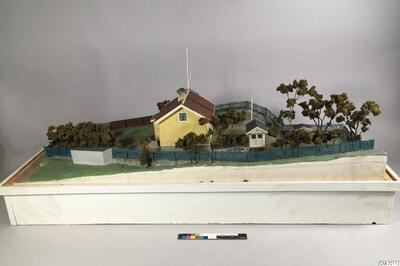


Similarity: 0.2303
File: _91668_GSM_objekt_1206311_oljemålning målning bilder.jpg


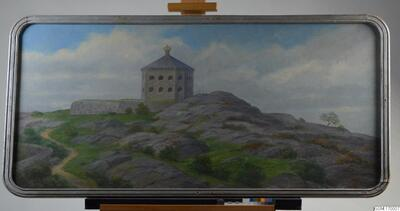


Similarity: 0.2266
File: _91668_GSM_objekt_10141_hörnskåp skåp nyckelskåp.jpg


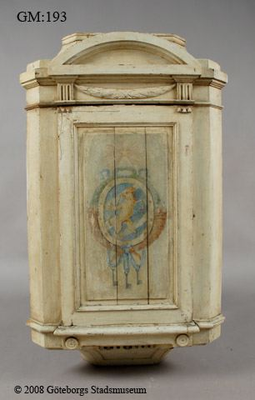


Similarity: 0.2205
File: _91668_GSM_objekt_14727_leksaksbåt leksaker åkdon.jpg


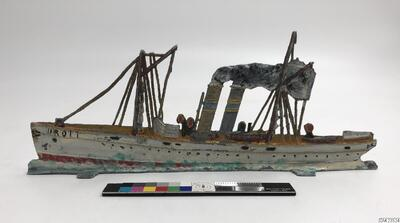


Similarity: 0.2194
File: _91668_GSM_objekt_15110_bro prydnadsföremål.jpg


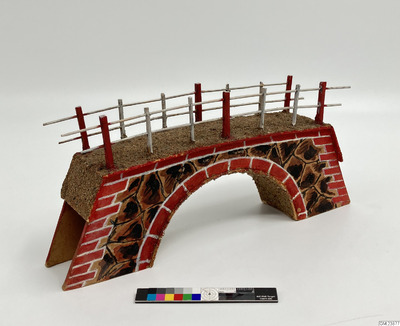

In [13]:
# Display the top results
if CLIP_AVAILABLE and image_embeddings is not None and results:
    print(f"\n🖼️ Displaying top results for '{SEARCH_QUERY}':\n")
    display_results(results, max_display=5)

---

## Part 6: Compare Different Queries

See how different phrasings affect search results.

In [14]:
# Compare different ways to search for water
QUERIES_TO_COMPARE = [
    "water",
    "river",
    "lake",
    "ocean waves",
    "waterfall"
]

if CLIP_AVAILABLE and image_embeddings is not None:
    print("Comparing queries - showing top result for each:\n")
    print("=" * 60)
    
    for query in QUERIES_TO_COMPARE:
        results = semantic_search(query, top_k=1, use_ensemble=False)
        if results:
            filename, score = results[0]
            print(f"'{query}'")
            print(f"  → {score:.4f} - {Path(filename).name[:45]}")
            print()

Comparing queries - showing top result for each:

'water'
  → 0.2173 - _91668_GSM_objekt_13831_leksak smörkärna husg

'river'
  → 0.2185 - _91668_GSM_objekt_15110_bro prydnadsföremål.j

'lake'
  → 0.2121 - _91668_GSM_objekt_10975_modeller husmodell to

'ocean waves'
  → 0.2015 - _91668_GSM_objekt_10876_dräkttillbehör solfjä

'waterfall'
  → 0.2012 - _91668_GSM_objekt_15035_dockskåpsföremål blom



In [15]:
# ============================================================
# ADVANCED: Create custom prompt ensemble
# ============================================================

CUSTOM_PROMPTS = [
    "water near the shore",
    "beach scene with ocean",
    "coastal landscape",
    "waves on the beach",
    "seaside view"
]

# ============================================================

if CLIP_AVAILABLE and image_embeddings is not None:
    print("Using custom prompt ensemble:")
    for p in CUSTOM_PROMPTS:
        print(f"  - {p}")
    print()
    
    # Encode and average
    custom_embedding = encode_text_ensemble(CUSTOM_PROMPTS)
    
    # Search
    similarities = (image_embeddings @ custom_embedding.T).squeeze()
    top_indices = similarities.argsort(descending=True)[:10]
    
    print("Top 10 results:")
    for i, idx in enumerate(top_indices, 1):
        filename = str(image_filenames[idx.item()])
        score = similarities[idx].item()
        print(f"{i:2}. {score:.4f} - {Path(filename).name[:50]}")

Using custom prompt ensemble:
  - water near the shore
  - beach scene with ocean
  - coastal landscape
  - waves on the beach
  - seaside view

Top 10 results:
 1. 0.2380 - _91668_GSM_objekt_10975_modeller husmodell tomtmod
 2. 0.2212 - _91668_GSM_objekt_1206311_oljemålning målning bild
 3. 0.2123 - _91668_GSM_objekt_10876_dräkttillbehör solfjäder.j
 4. 0.2112 - _91668_GSM_objekt_14727_leksaksbåt leksaker åkdon.
 5. 0.2077 - _91668_GSM_objekt_12924_solfjäder dräkttillbehör.j
 6. 0.2039 - _91668_GSM_objekt_10141_hörnskåp skåp nyckelskåp.j
 7. 0.2034 - _91668_GSM_objekt_10206_solfjäder.jpg
 8. 0.2007 - _91668_GSM_objekt_10769_solfjäder dräkttillbehör.j
 9. 0.1982 - _91668_GSM_objekt_1427457_tavla akvarell bilder må
10. 0.1962 - _91668_GSM_objekt_13811_bärdon ok.jpg


---

## Part 7: Save Search Results

Save your search results for further analysis.

In [ ]:
def save_search_results(results, query, output_dir=None):
    """Save search results to a JSON file."""
    if output_dir is None:
        output_dir = DATA_DIR
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    safe_query = "".join(c for c in query if c.isalnum() or c in ' _-')[:40]
    filename = f"clip_search_{safe_query.replace(' ', '_')}.json"
    output_path = output_dir / filename
    
    data = {
        'query': query,
        'model': MODEL_NAME,
        'results': [
            {'filename': f, 'similarity': s}
            for f, s in results
        ]
    }
    
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"✓ Saved {len(results)} results to {output_path}")


# Save your search results
if 'results' in dir() and results:
    save_search_results(results, SEARCH_QUERY)

---

## Summary

In this notebook, you learned:

1. **How to download** images from a specific Europeana collection (Uppsala University)
2. **What CLIP is** and how it connects images and text
3. **How to search** images using natural language queries
4. **How prompt engineering** affects search results
5. **How to compare** different queries

### Key Concepts

- **Embeddings**: Numerical representations that capture meaning
- **Cosine similarity**: Measures how similar two embeddings are
- **Prompt ensembling**: Using multiple prompts for better results
- **Semantic search**: Finding images by meaning, not keywords

### Next Steps

- **Notebook 03**: Upload your own photo and find similar images in the collection
- **Notebook 04** (Advanced): Compute embeddings from your own images (requires GPU)